## GAN starter code
Corresponding tutorial: [https://youtu.be/_pIMdDWK5sc](https://youtu.be/_pIMdDWK5sc)

In [17]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl


BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [18]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data",
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [19]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [20]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]


    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256

        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [21]:
from typing import Any

from pytorch_lightning.utilities.types import OptimizerLRScheduler


class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100,lr=0.00002):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False
        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        #random noise
        self.validation_z = torch.randn(6,self.hparams.latent_dim)

    def forward(self,z):
        return self.generator(z)
    

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat,y)
    
    def training_step(self,batch ):
        imgs, _ = batch

        optimizer_g, optimizer_d = self.optimizers()

        # sample noise
        z = torch.randn(imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(imgs)

        # train generator
        # generate images
        self.toggle_optimizer(optimizer_g)
        self.generated_imgs = self(z)

        # log sampled images
        sample_imgs = self.generated_imgs[:6]
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image("generated_images", grid, 0)

        # ground truth result (ie: all fake)
        # put on GPU because we created this tensor inside training_loop
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)

        # adversarial loss is binary cross-entropy
        g_loss = self.adversarial_loss(self.discriminator(self(z)), valid)
        self.log("g_loss", g_loss, prog_bar=True)
        self.manual_backward(g_loss)
        optimizer_g.step()
        optimizer_g.zero_grad()
        self.untoggle_optimizer(optimizer_g)

        # train discriminator
        # Measure discriminator's ability to classify real from generated samples
        self.toggle_optimizer(optimizer_d)

        # how well can it label as real?
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)

        real_loss = self.adversarial_loss(self.discriminator(imgs), valid)

        # how well can it label as fake?
        fake = torch.zeros(imgs.size(0), 1)
        fake = fake.type_as(imgs)

        fake_loss = self.adversarial_loss(self.discriminator(self(z).detach()), fake)

        # discriminator loss is the average of these
        d_loss = (real_loss + fake_loss) / 2
        self.log("d_loss", d_loss, prog_bar=True)
        self.manual_backward(d_loss)
        optimizer_d.step()
        optimizer_d.zero_grad()
        self.untoggle_optimizer(optimizer_d)


    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(),lr = lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(),lr = lr)
        return [opt_g, opt_d] , []
    
    def plot_imgs(self):
        z=self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()

        print('epoch ',self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2,3,i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i,0,:,:], cmap='gray_r' , interpolation='none')
            plt.title("Generated Data")
            plt.xticks([])
            plt.yticks([])
            plt.axis("off")
        plt.show()

    def on_train_epoch_end(self):
        self.plot_imgs()


In [22]:
dm = MNISTDataModule()
model = GAN()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker ini

Epoch 0: 100%|██████████| 430/430 [00:10<00:00, 40.79it/s, v_num=27, g_loss=0.803, d_loss=0.436]epoch  0


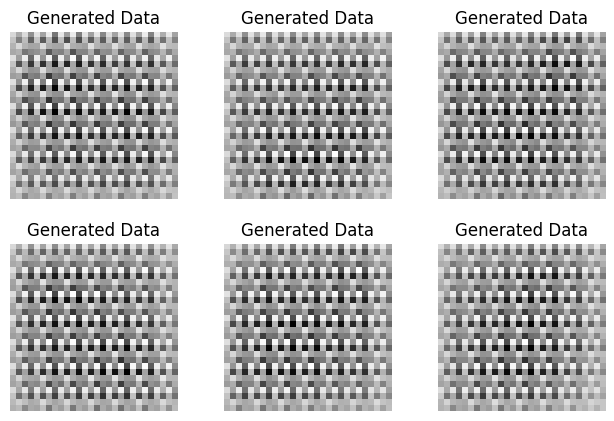

Epoch 1: 100%|██████████| 430/430 [00:25<00:00, 16.74it/s, v_num=27, g_loss=0.946, d_loss=0.276]epoch  1


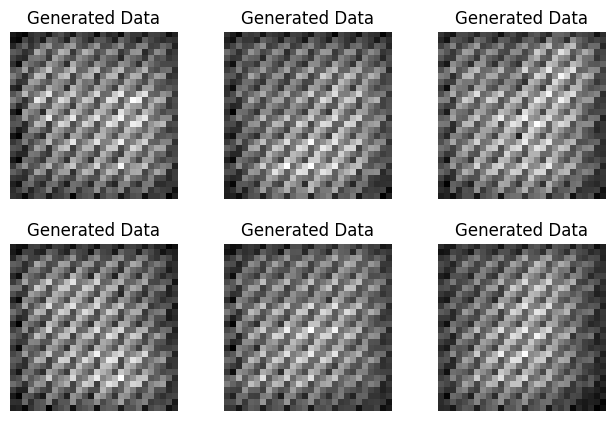

Epoch 2: 100%|██████████| 430/430 [00:23<00:00, 18.22it/s, v_num=27, g_loss=0.999, d_loss=0.266]epoch  2


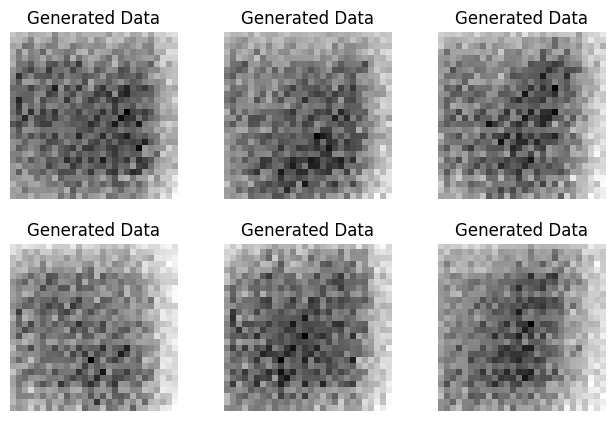

Epoch 3: 100%|██████████| 430/430 [00:24<00:00, 17.62it/s, v_num=27, g_loss=1.410, d_loss=0.163]epoch  3


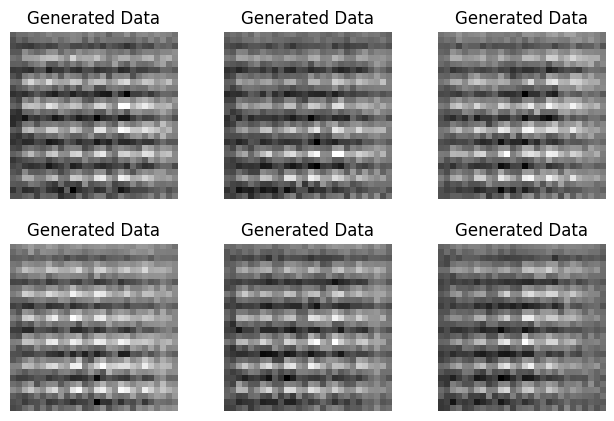

Epoch 4: 100%|██████████| 430/430 [00:24<00:00, 17.84it/s, v_num=27, g_loss=1.990, d_loss=0.0925]epoch  4


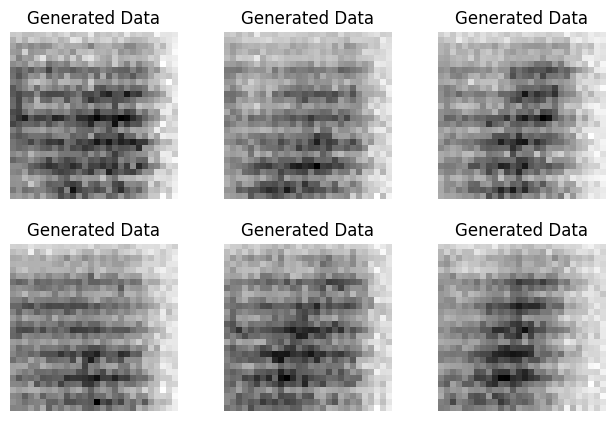

Epoch 5: 100%|██████████| 430/430 [00:24<00:00, 17.41it/s, v_num=27, g_loss=2.770, d_loss=0.0712]epoch  5


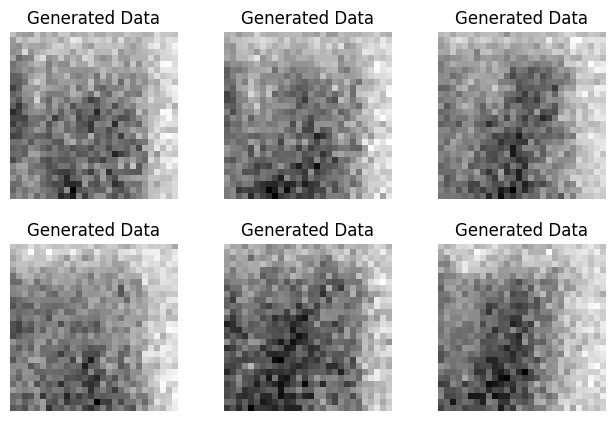

Epoch 6: 100%|██████████| 430/430 [00:24<00:00, 17.79it/s, v_num=27, g_loss=3.400, d_loss=0.0519]epoch  6


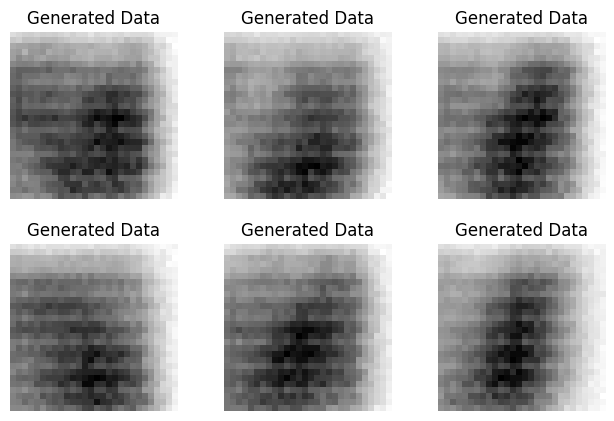

Epoch 7: 100%|██████████| 430/430 [00:24<00:00, 17.41it/s, v_num=27, g_loss=4.350, d_loss=0.144] epoch  7


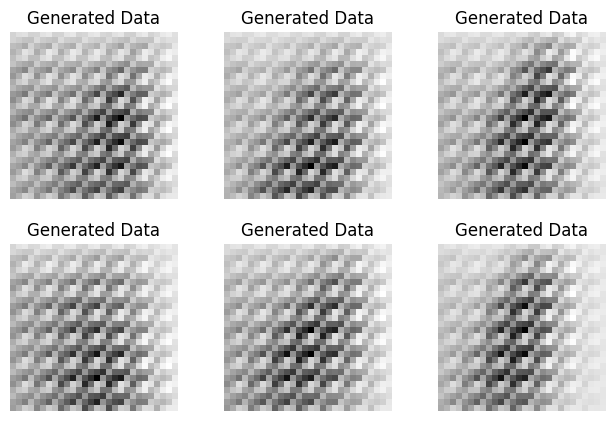

Epoch 8: 100%|██████████| 430/430 [00:25<00:00, 17.09it/s, v_num=27, g_loss=2.500, d_loss=0.181]epoch  8


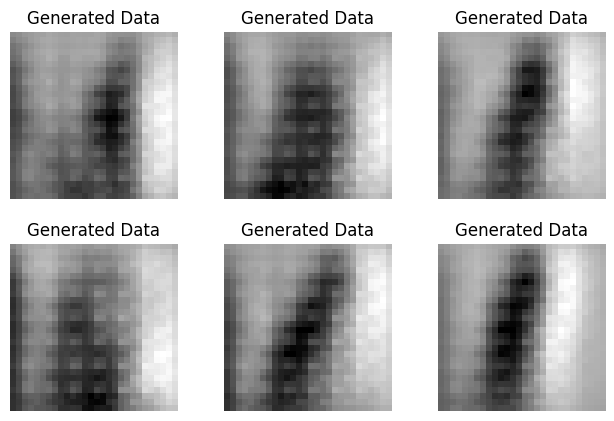

Epoch 9: 100%|██████████| 430/430 [00:24<00:00, 17.39it/s, v_num=27, g_loss=2.280, d_loss=0.185]epoch  9


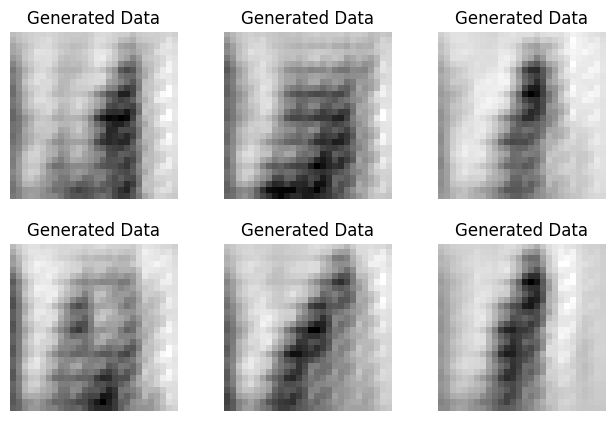

Epoch 10: 100%|██████████| 430/430 [00:25<00:00, 17.12it/s, v_num=27, g_loss=2.590, d_loss=0.207]epoch  10


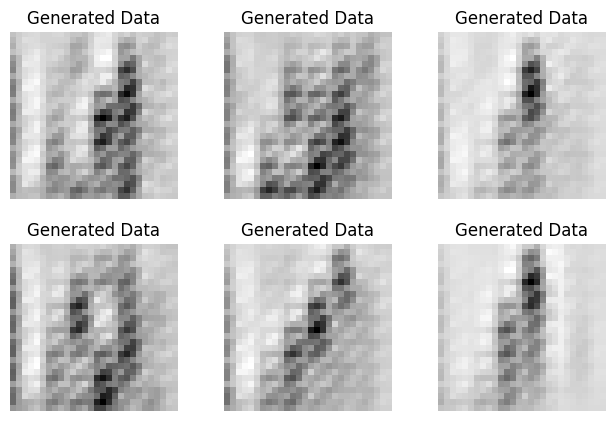

Epoch 11: 100%|██████████| 430/430 [00:24<00:00, 17.67it/s, v_num=27, g_loss=2.830, d_loss=0.177]epoch  11


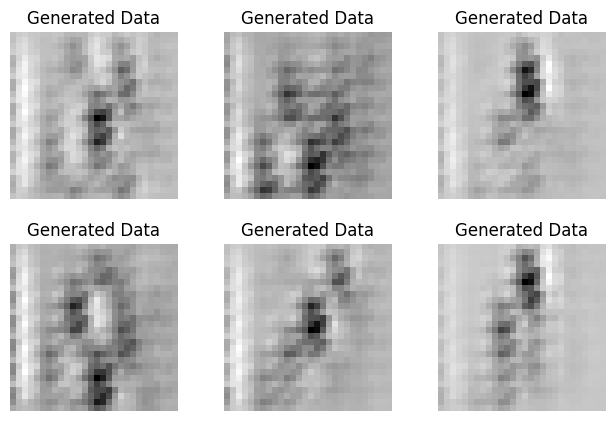

Epoch 12: 100%|██████████| 430/430 [00:24<00:00, 17.68it/s, v_num=27, g_loss=2.230, d_loss=0.266]epoch  12


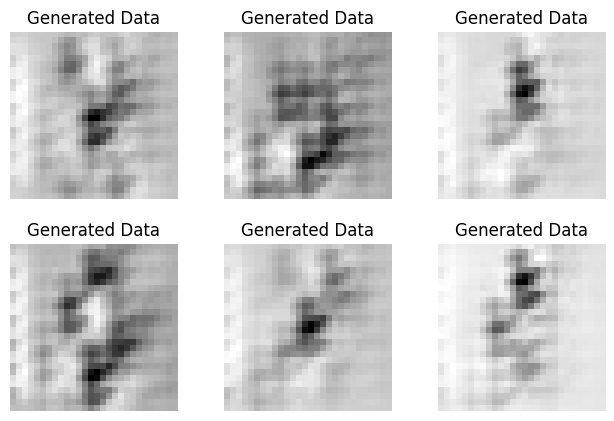

Epoch 13: 100%|██████████| 430/430 [00:24<00:00, 17.22it/s, v_num=27, g_loss=1.730, d_loss=0.389]epoch  13


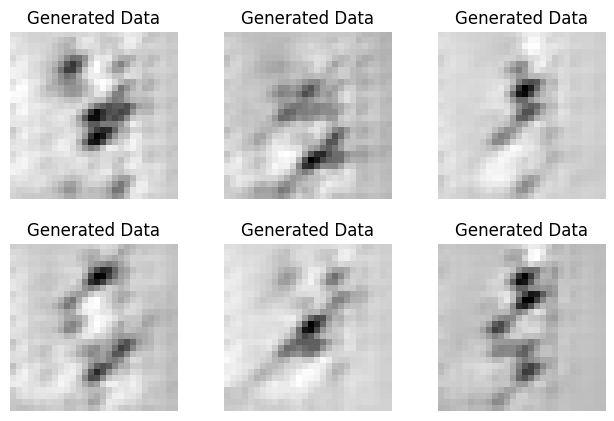

Epoch 14: 100%|██████████| 430/430 [00:25<00:00, 17.07it/s, v_num=27, g_loss=1.760, d_loss=0.369]epoch  14


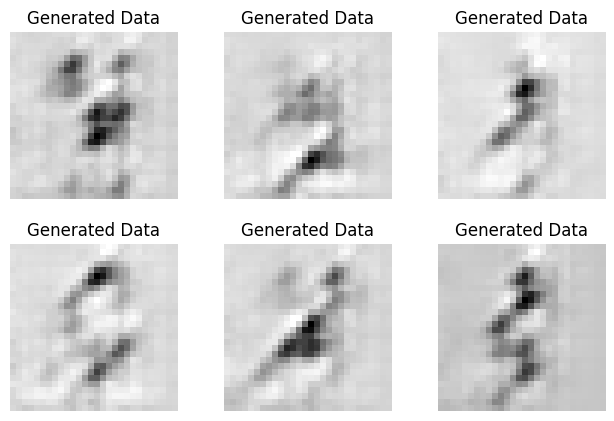

Epoch 15: 100%|██████████| 430/430 [00:24<00:00, 17.47it/s, v_num=27, g_loss=2.300, d_loss=0.284]epoch  15


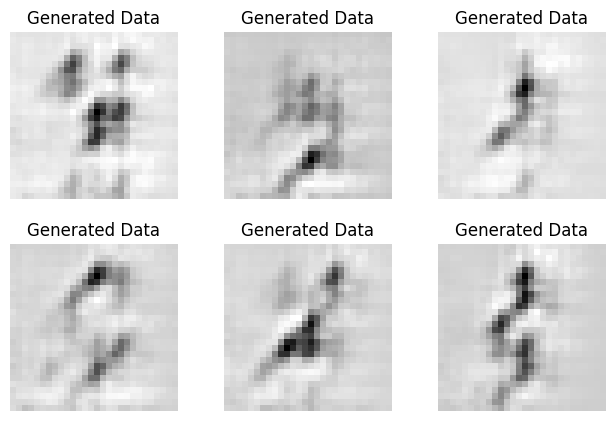

Epoch 16: 100%|██████████| 430/430 [00:24<00:00, 17.40it/s, v_num=27, g_loss=1.960, d_loss=0.284]epoch  16


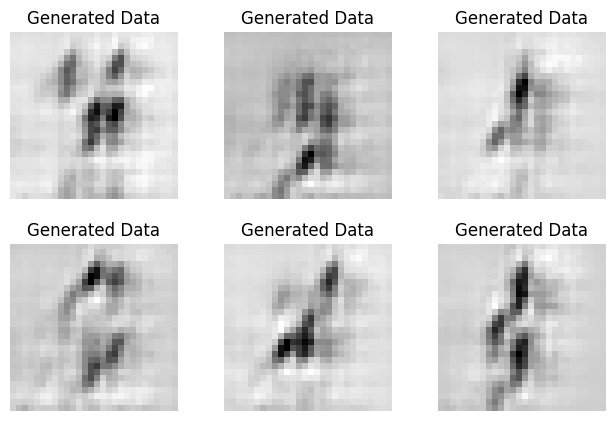

Epoch 17: 100%|██████████| 430/430 [00:24<00:00, 17.50it/s, v_num=27, g_loss=2.110, d_loss=0.297]epoch  17


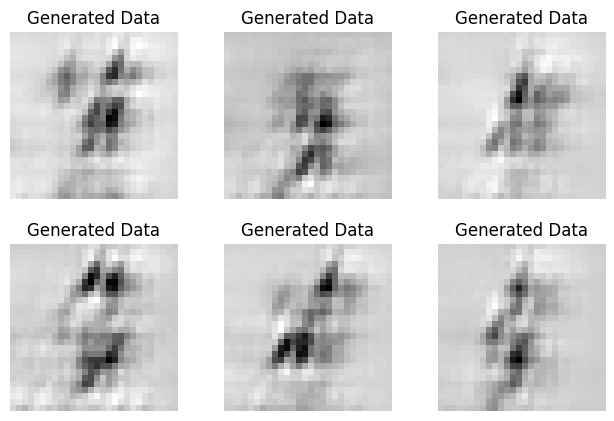

Epoch 18: 100%|██████████| 430/430 [00:24<00:00, 17.69it/s, v_num=27, g_loss=2.340, d_loss=0.243]epoch  18


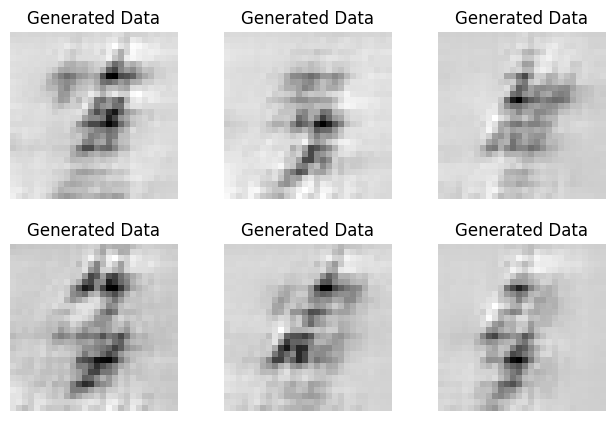

Epoch 19: 100%|██████████| 430/430 [00:24<00:00, 17.91it/s, v_num=27, g_loss=2.030, d_loss=0.205]epoch  19


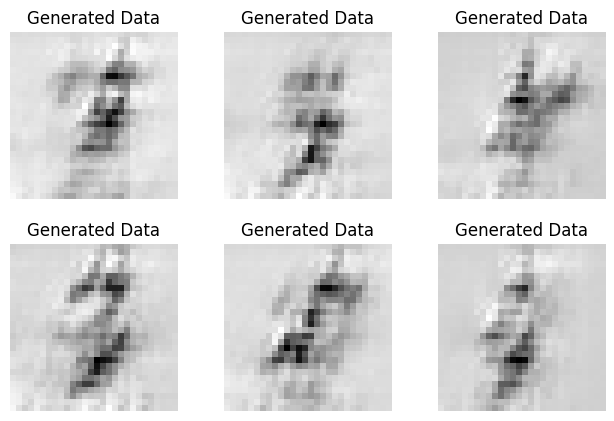

Epoch 20: 100%|██████████| 430/430 [00:24<00:00, 17.39it/s, v_num=27, g_loss=1.820, d_loss=0.237]epoch  20


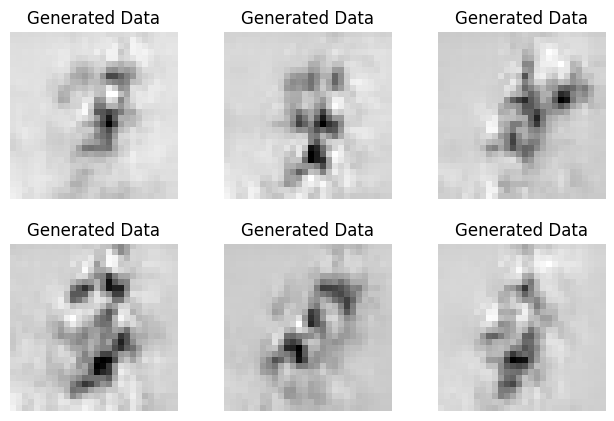

Epoch 21: 100%|██████████| 430/430 [00:24<00:00, 17.80it/s, v_num=27, g_loss=1.980, d_loss=0.251]epoch  21


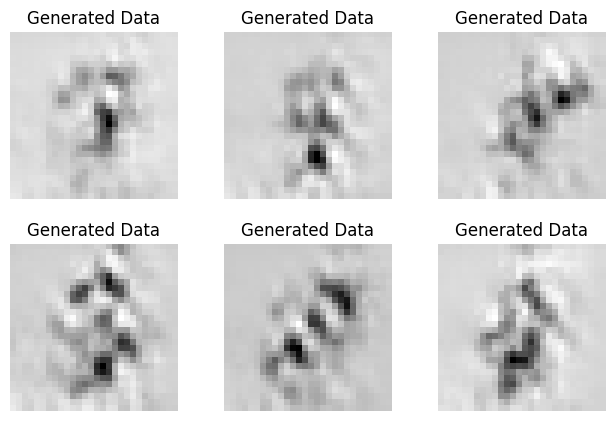

Epoch 22: 100%|██████████| 430/430 [00:24<00:00, 17.87it/s, v_num=27, g_loss=2.010, d_loss=0.274]epoch  22


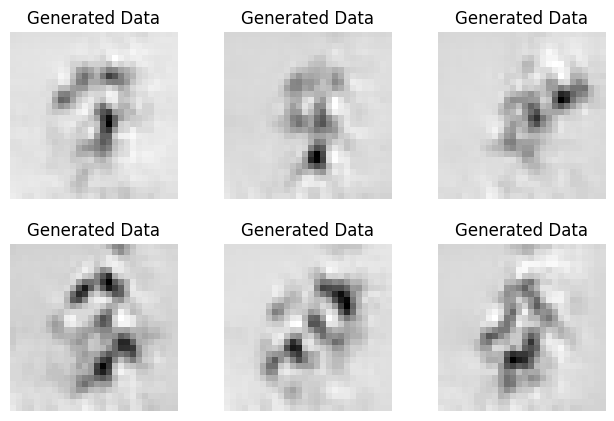

Epoch 23: 100%|██████████| 430/430 [00:24<00:00, 17.64it/s, v_num=27, g_loss=2.230, d_loss=0.312]epoch  23


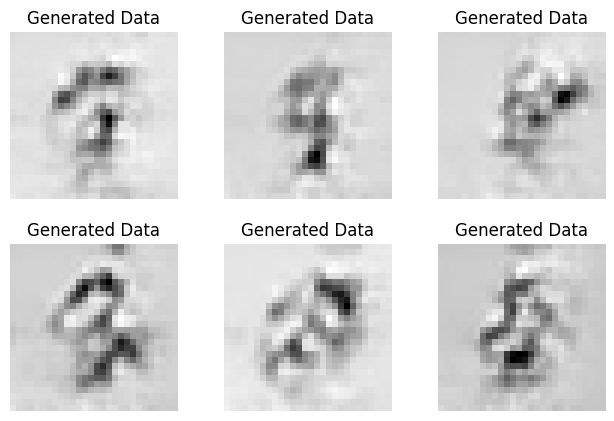

Epoch 24: 100%|██████████| 430/430 [00:24<00:00, 17.91it/s, v_num=27, g_loss=2.270, d_loss=0.240]epoch  24


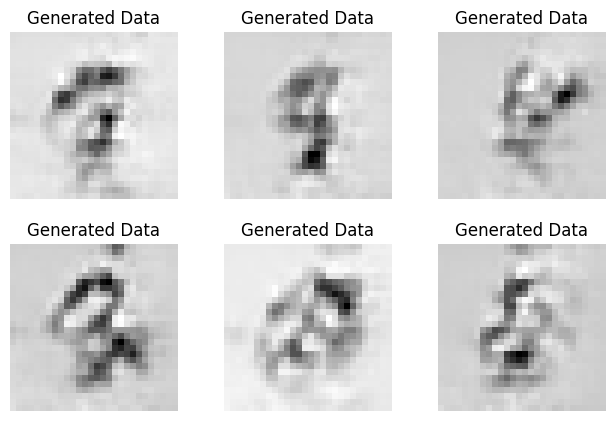

Epoch 25: 100%|██████████| 430/430 [00:24<00:00, 17.90it/s, v_num=27, g_loss=2.260, d_loss=0.251]epoch  25


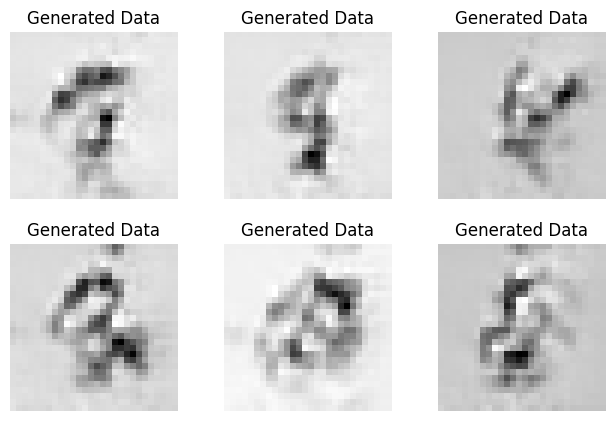

Epoch 26: 100%|██████████| 430/430 [00:24<00:00, 17.82it/s, v_num=27, g_loss=2.460, d_loss=0.231]epoch  26


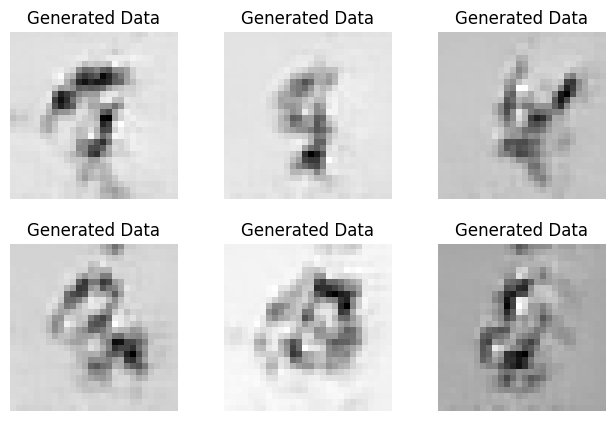

Epoch 27: 100%|██████████| 430/430 [00:23<00:00, 18.03it/s, v_num=27, g_loss=2.120, d_loss=0.205]epoch  27


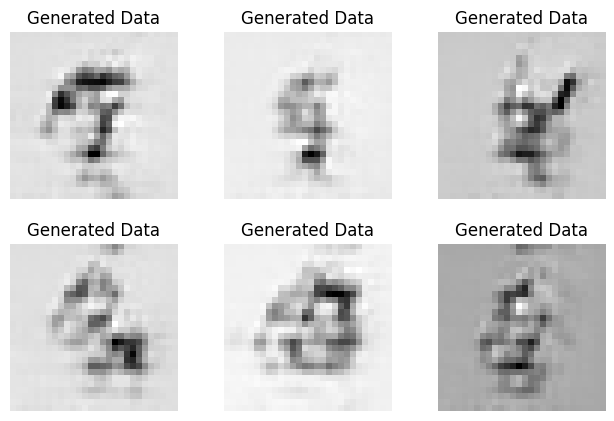

Epoch 28: 100%|██████████| 430/430 [00:24<00:00, 17.49it/s, v_num=27, g_loss=2.220, d_loss=0.304]epoch  28


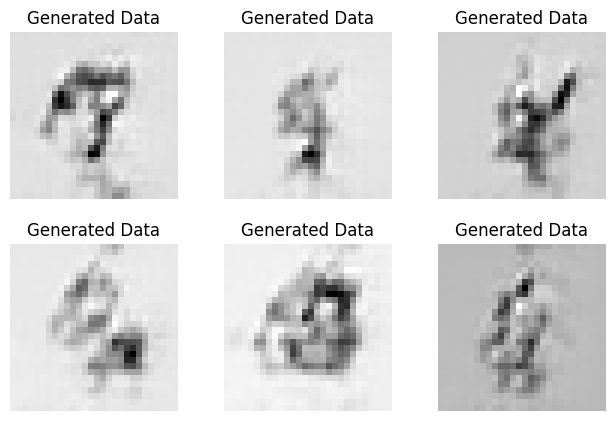

Epoch 29: 100%|██████████| 430/430 [00:25<00:00, 16.86it/s, v_num=27, g_loss=2.200, d_loss=0.194]epoch  29


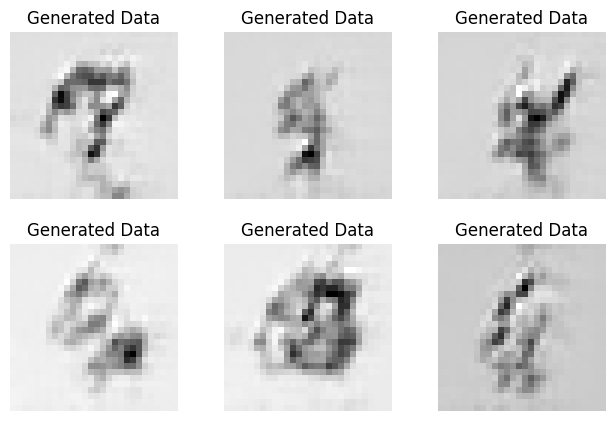

Epoch 30: 100%|██████████| 430/430 [00:24<00:00, 17.58it/s, v_num=27, g_loss=2.300, d_loss=0.196]epoch  30


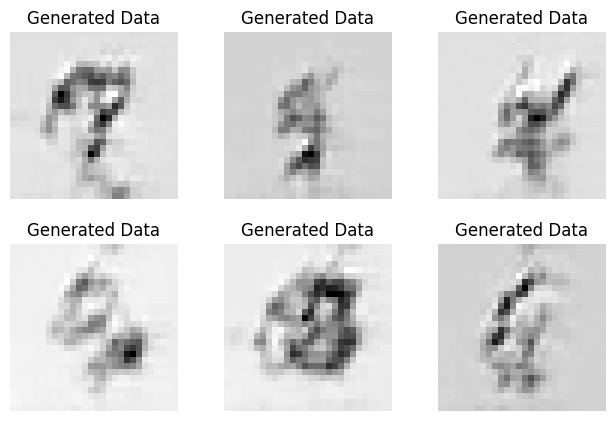

Epoch 31: 100%|██████████| 430/430 [00:24<00:00, 17.60it/s, v_num=27, g_loss=2.330, d_loss=0.205]epoch  31


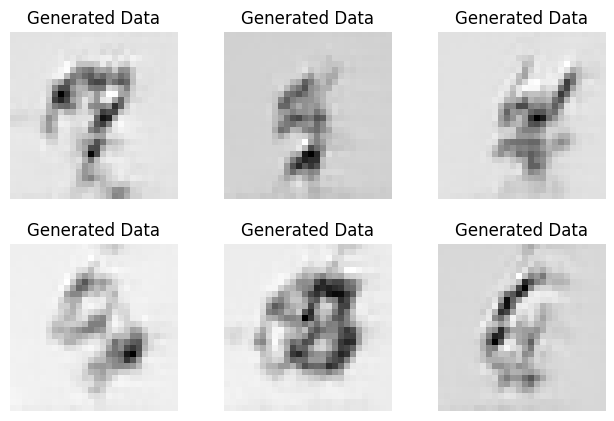

Epoch 32: 100%|██████████| 430/430 [00:24<00:00, 17.69it/s, v_num=27, g_loss=2.370, d_loss=0.240]epoch  32


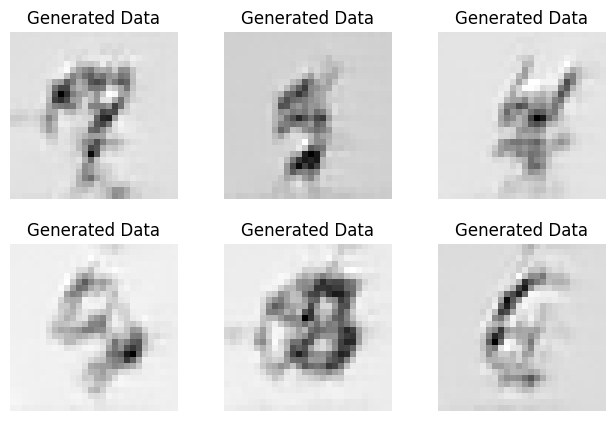

Epoch 33: 100%|██████████| 430/430 [00:24<00:00, 17.70it/s, v_num=27, g_loss=2.540, d_loss=0.195]epoch  33


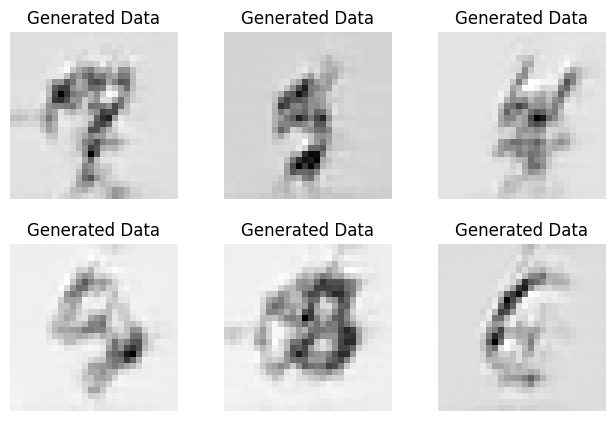

Epoch 34: 100%|██████████| 430/430 [00:23<00:00, 17.92it/s, v_num=27, g_loss=2.500, d_loss=0.201]epoch  34


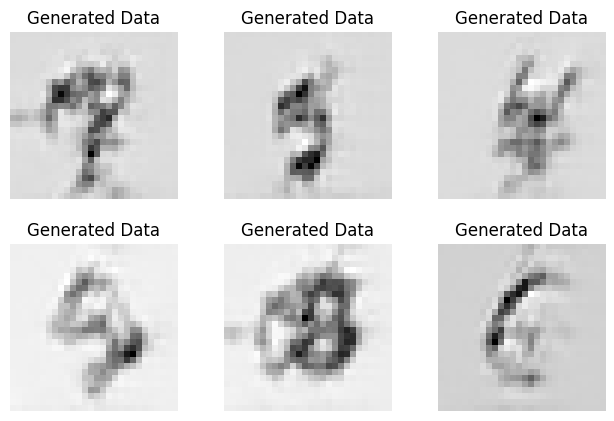

Epoch 35: 100%|██████████| 430/430 [00:24<00:00, 17.91it/s, v_num=27, g_loss=2.300, d_loss=0.228]epoch  35


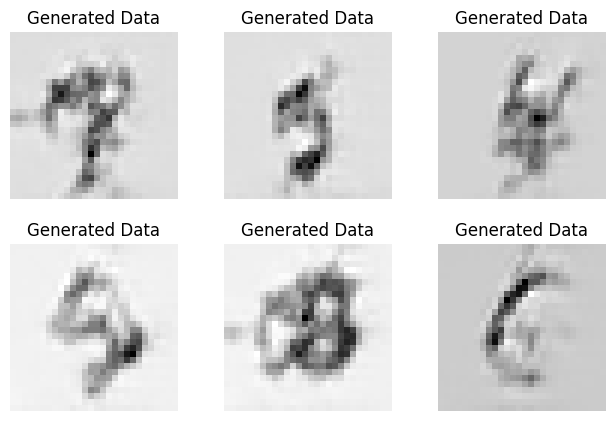

Epoch 36: 100%|██████████| 430/430 [00:23<00:00, 17.93it/s, v_num=27, g_loss=2.450, d_loss=0.231]epoch  36


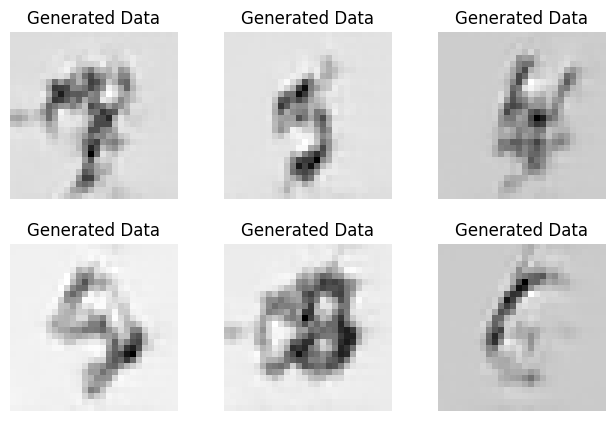

Epoch 37: 100%|██████████| 430/430 [00:24<00:00, 17.80it/s, v_num=27, g_loss=2.610, d_loss=0.225]epoch  37


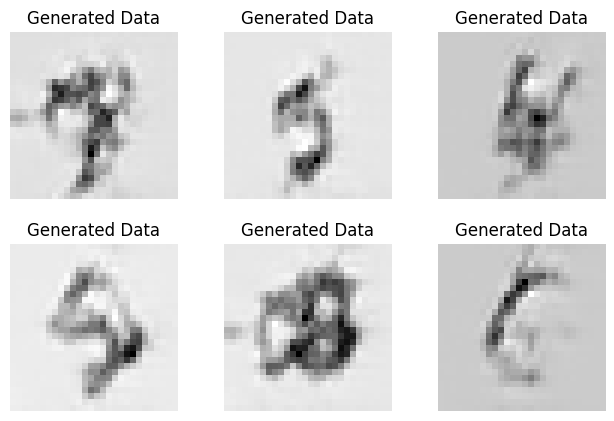

Epoch 38: 100%|██████████| 430/430 [00:24<00:00, 17.70it/s, v_num=27, g_loss=2.500, d_loss=0.244]epoch  38


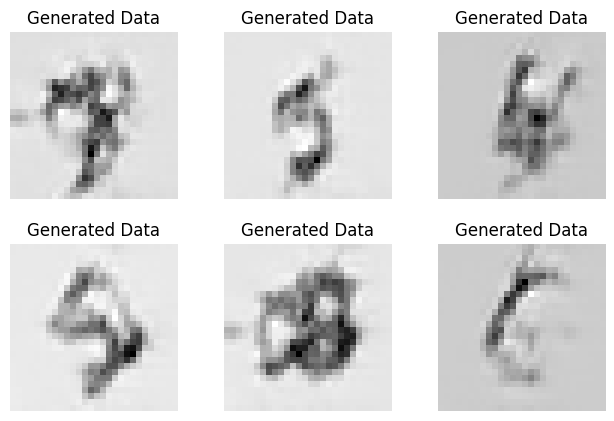

Epoch 39: 100%|██████████| 430/430 [00:23<00:00, 18.01it/s, v_num=27, g_loss=2.290, d_loss=0.267]epoch  39


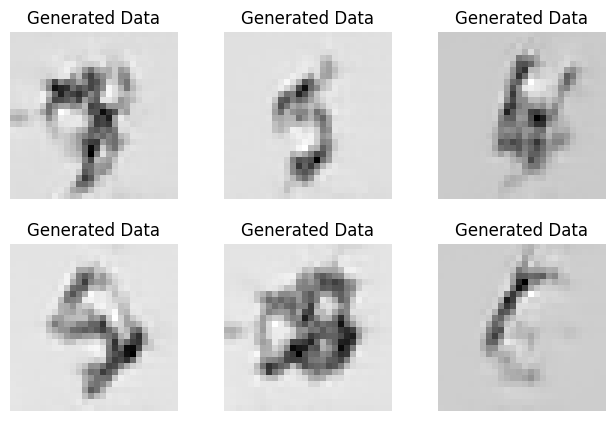

Epoch 40: 100%|██████████| 430/430 [00:24<00:00, 17.58it/s, v_num=27, g_loss=2.480, d_loss=0.190]epoch  40


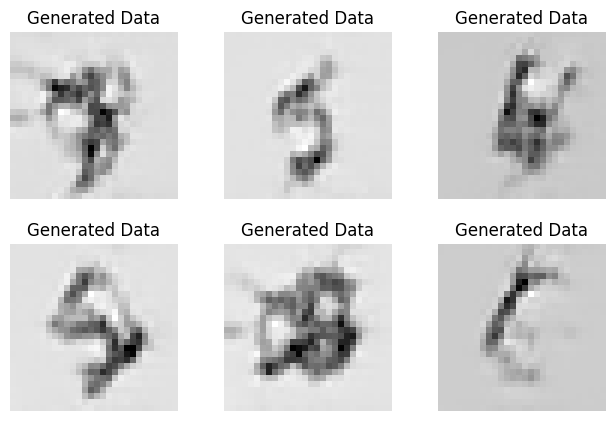

Epoch 41: 100%|██████████| 430/430 [00:24<00:00, 17.37it/s, v_num=27, g_loss=2.410, d_loss=0.291]epoch  41


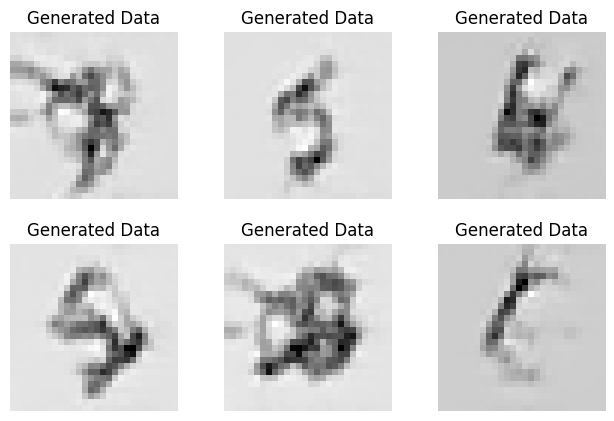

Epoch 42: 100%|██████████| 430/430 [00:24<00:00, 17.64it/s, v_num=27, g_loss=2.580, d_loss=0.226]epoch  42


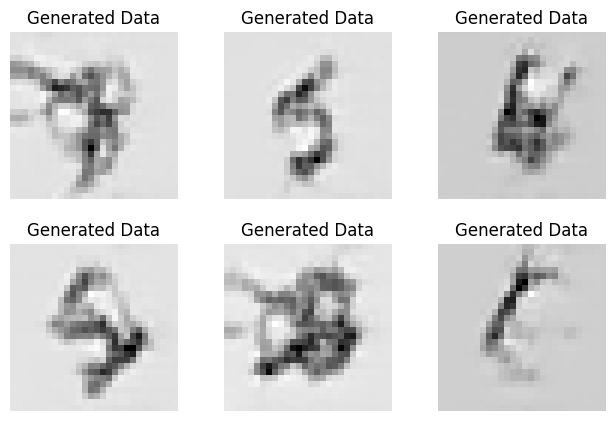

Epoch 43: 100%|██████████| 430/430 [00:24<00:00, 17.35it/s, v_num=27, g_loss=2.390, d_loss=0.237]epoch  43


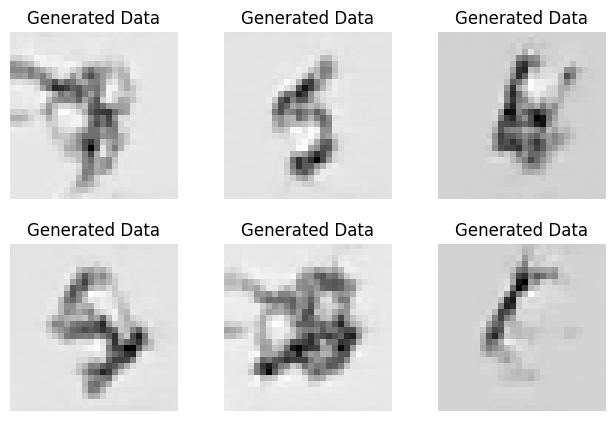

Epoch 44: 100%|██████████| 430/430 [00:24<00:00, 17.36it/s, v_num=27, g_loss=2.550, d_loss=0.231]epoch  44


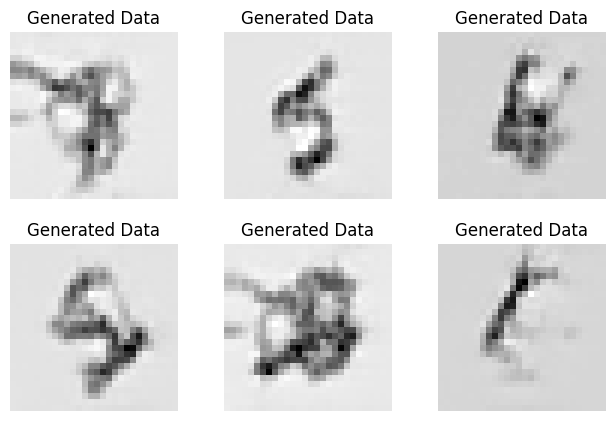

Epoch 45: 100%|██████████| 430/430 [00:24<00:00, 17.67it/s, v_num=27, g_loss=2.640, d_loss=0.250]epoch  45


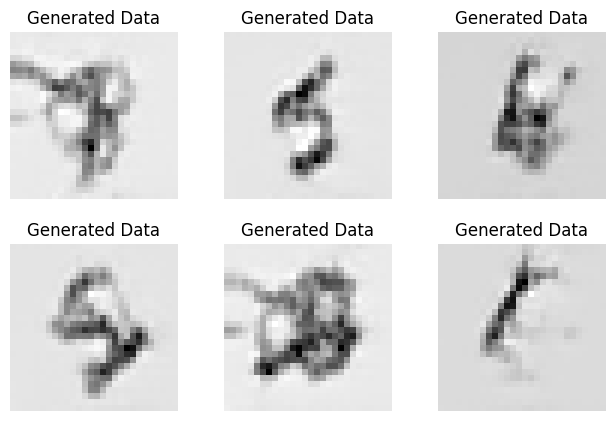

Epoch 46: 100%|██████████| 430/430 [00:24<00:00, 17.79it/s, v_num=27, g_loss=2.620, d_loss=0.253]epoch  46


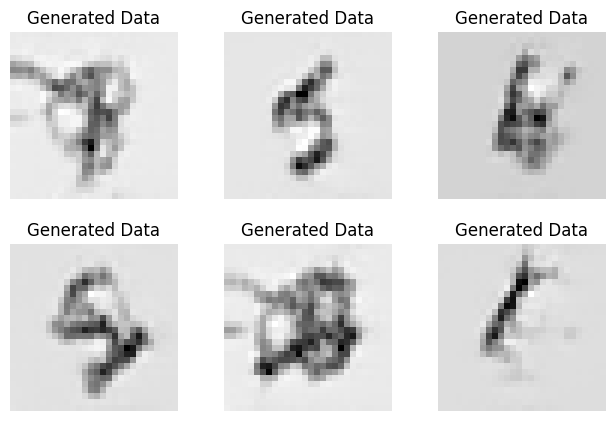

Epoch 47: 100%|██████████| 430/430 [00:24<00:00, 17.79it/s, v_num=27, g_loss=2.480, d_loss=0.160]epoch  47


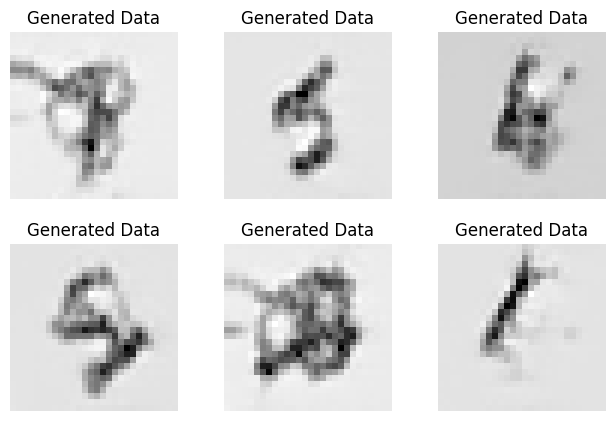

Epoch 48: 100%|██████████| 430/430 [00:24<00:00, 17.90it/s, v_num=27, g_loss=2.680, d_loss=0.175]epoch  48


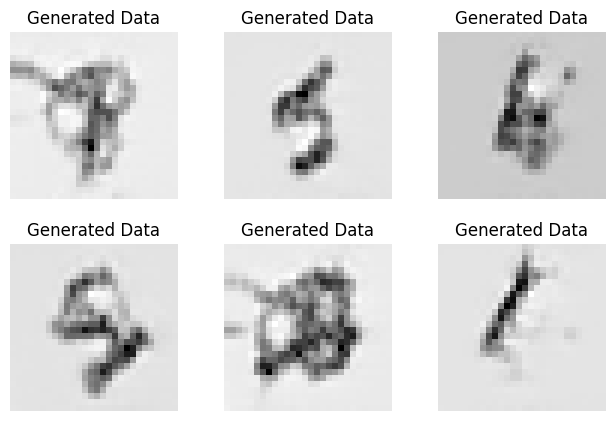

Epoch 49: 100%|██████████| 430/430 [00:23<00:00, 17.95it/s, v_num=27, g_loss=2.480, d_loss=0.158]epoch  49


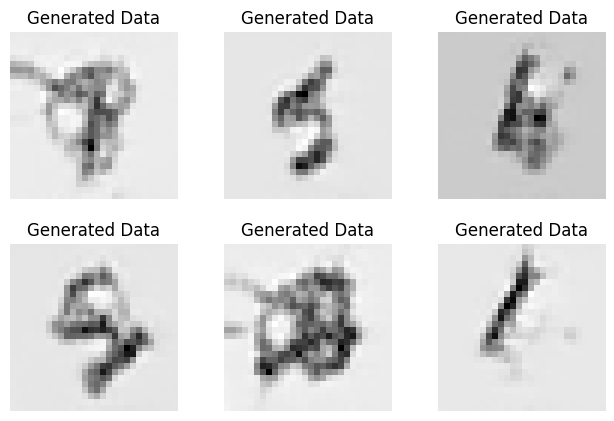

Epoch 50: 100%|██████████| 430/430 [00:24<00:00, 17.73it/s, v_num=27, g_loss=2.570, d_loss=0.194]epoch  50


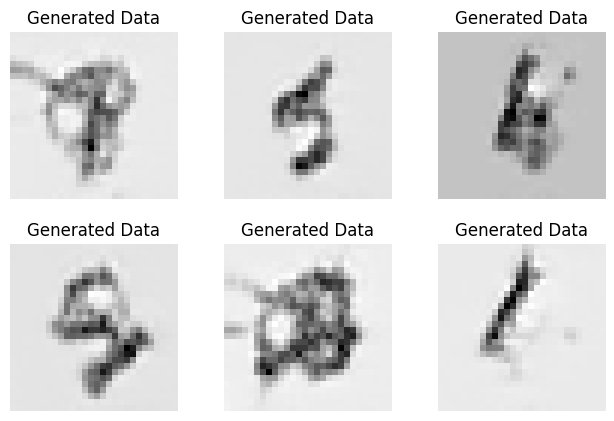

Epoch 51: 100%|██████████| 430/430 [00:24<00:00, 17.85it/s, v_num=27, g_loss=2.860, d_loss=0.189]epoch  51


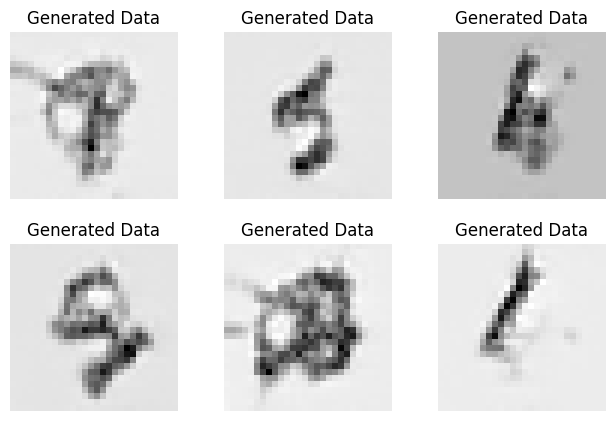

Epoch 52: 100%|██████████| 430/430 [00:24<00:00, 17.70it/s, v_num=27, g_loss=2.590, d_loss=0.218]epoch  52


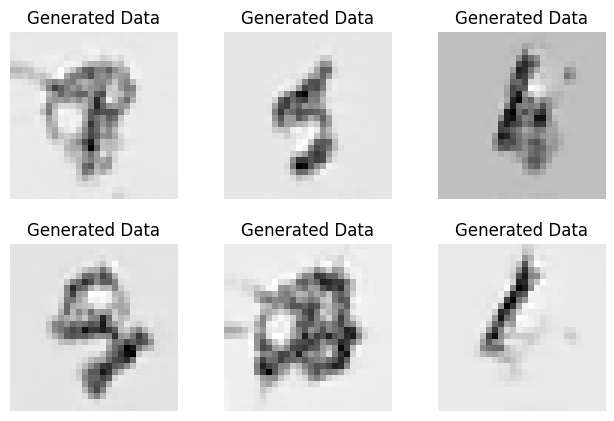

Epoch 53: 100%|██████████| 430/430 [00:24<00:00, 17.36it/s, v_num=27, g_loss=2.570, d_loss=0.157]epoch  53


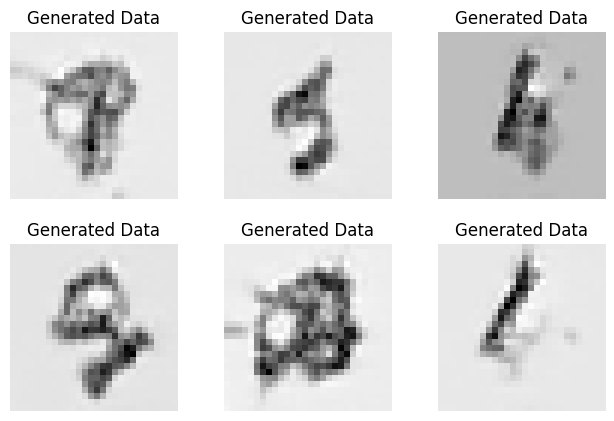

Epoch 54: 100%|██████████| 430/430 [00:24<00:00, 17.73it/s, v_num=27, g_loss=2.450, d_loss=0.219]epoch  54


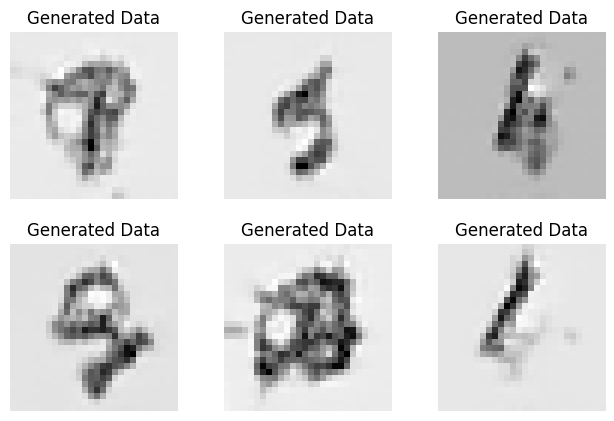

Epoch 55: 100%|██████████| 430/430 [00:24<00:00, 17.65it/s, v_num=27, g_loss=2.530, d_loss=0.236]epoch  55


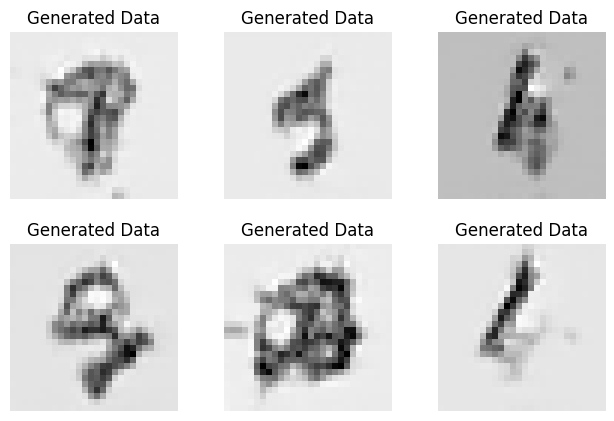

Epoch 56: 100%|██████████| 430/430 [00:24<00:00, 17.77it/s, v_num=27, g_loss=2.400, d_loss=0.184]epoch  56


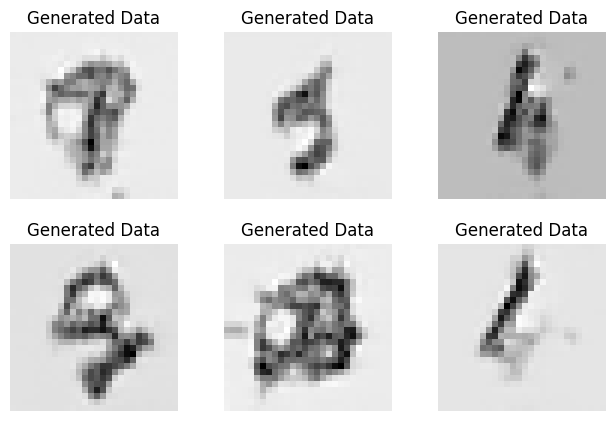

Epoch 57: 100%|██████████| 430/430 [00:24<00:00, 17.78it/s, v_num=27, g_loss=2.390, d_loss=0.232]epoch  57


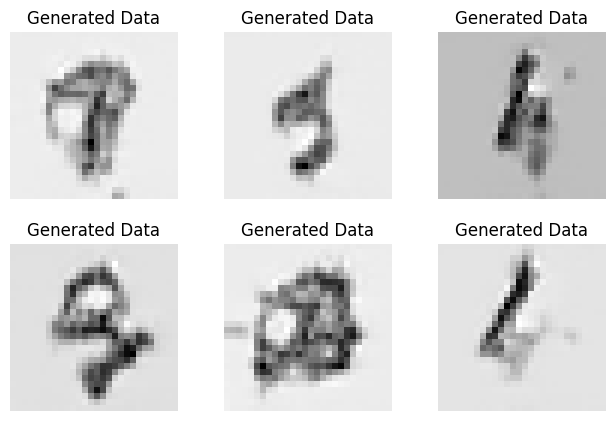

Epoch 58: 100%|██████████| 430/430 [00:24<00:00, 17.52it/s, v_num=27, g_loss=2.540, d_loss=0.188]epoch  58


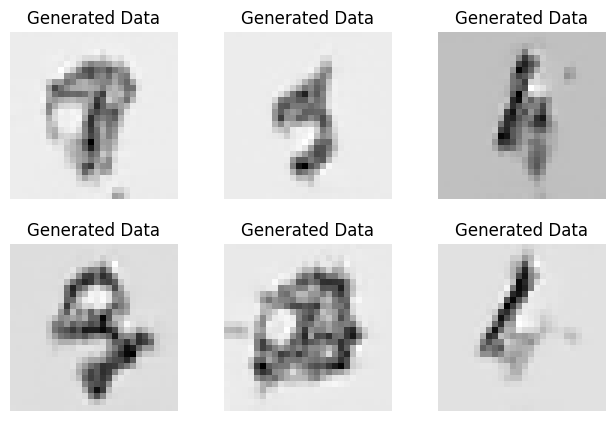

Epoch 59: 100%|██████████| 430/430 [00:25<00:00, 17.05it/s, v_num=27, g_loss=2.300, d_loss=0.307]epoch  59


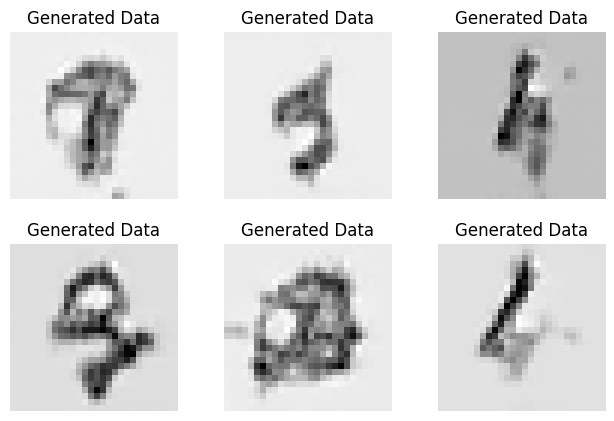

Epoch 60: 100%|██████████| 430/430 [00:24<00:00, 17.45it/s, v_num=27, g_loss=2.310, d_loss=0.247]epoch  60


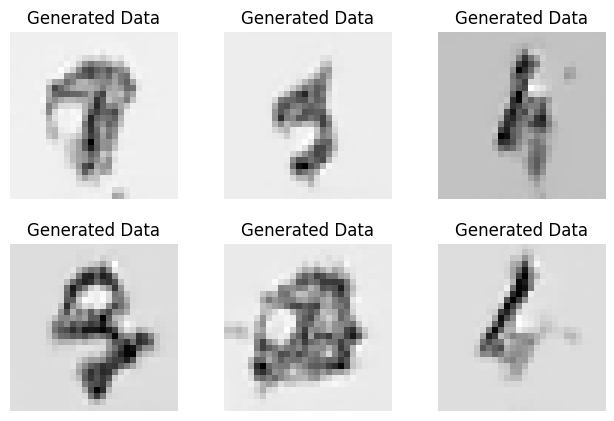

Epoch 61: 100%|██████████| 430/430 [00:24<00:00, 17.64it/s, v_num=27, g_loss=2.270, d_loss=0.258]epoch  61


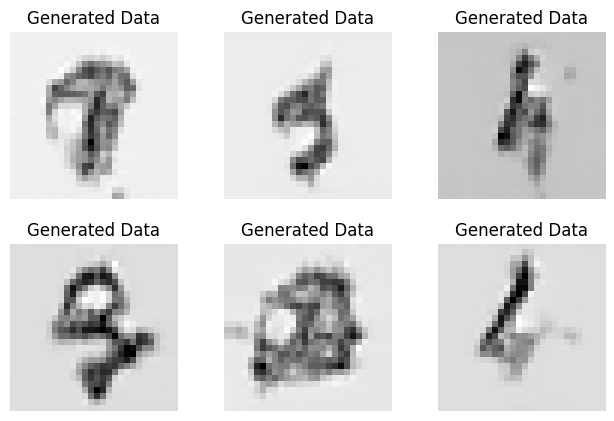

Epoch 62: 100%|██████████| 430/430 [00:24<00:00, 17.84it/s, v_num=27, g_loss=2.450, d_loss=0.239]epoch  62


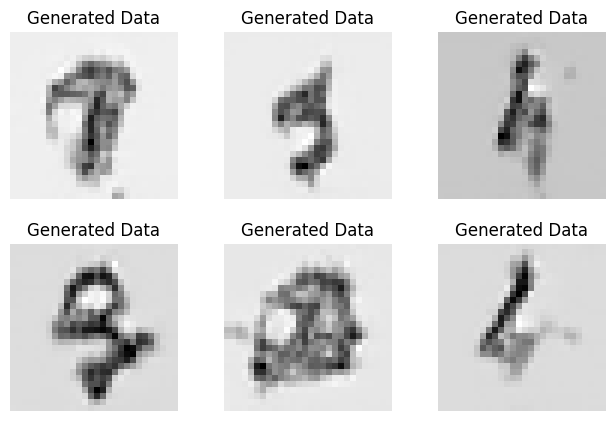

Epoch 63: 100%|██████████| 430/430 [00:24<00:00, 17.81it/s, v_num=27, g_loss=2.590, d_loss=0.278]epoch  63


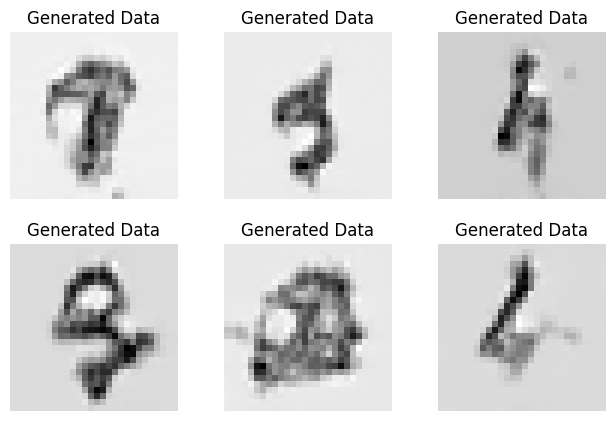

Epoch 64: 100%|██████████| 430/430 [00:24<00:00, 17.72it/s, v_num=27, g_loss=2.260, d_loss=0.316]epoch  64


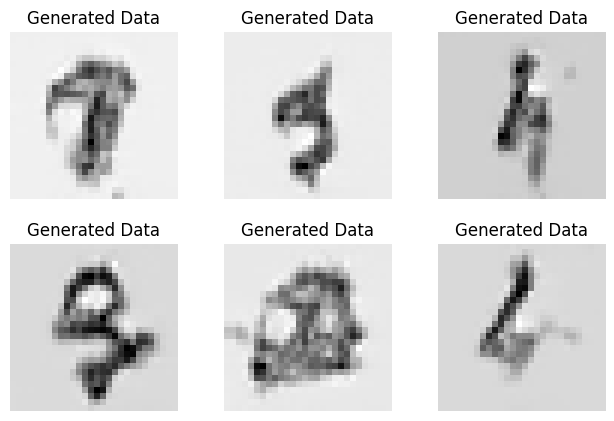

Epoch 65: 100%|██████████| 430/430 [00:24<00:00, 17.48it/s, v_num=27, g_loss=2.220, d_loss=0.218]epoch  65


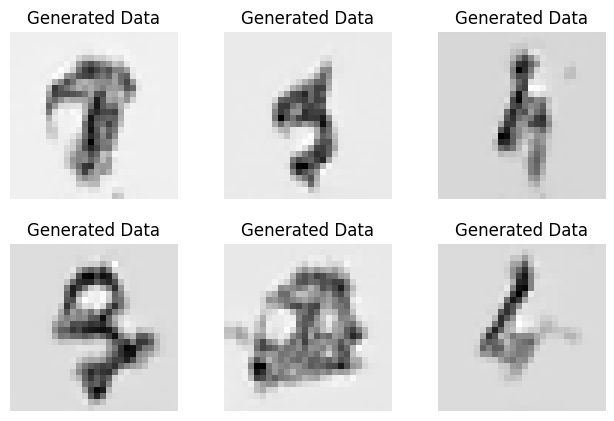

Epoch 66: 100%|██████████| 430/430 [00:24<00:00, 17.71it/s, v_num=27, g_loss=2.180, d_loss=0.255]epoch  66


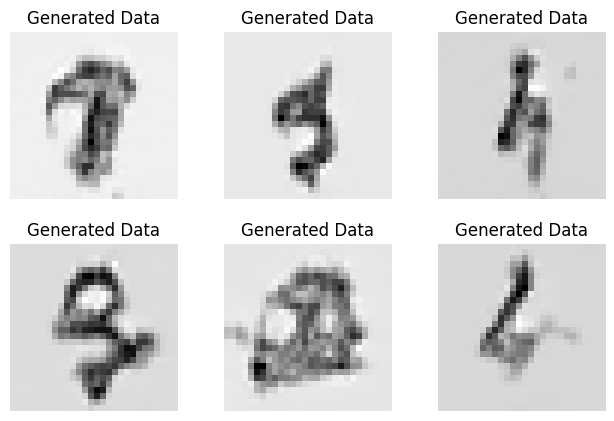

Epoch 67: 100%|██████████| 430/430 [00:24<00:00, 17.76it/s, v_num=27, g_loss=2.360, d_loss=0.279]epoch  67


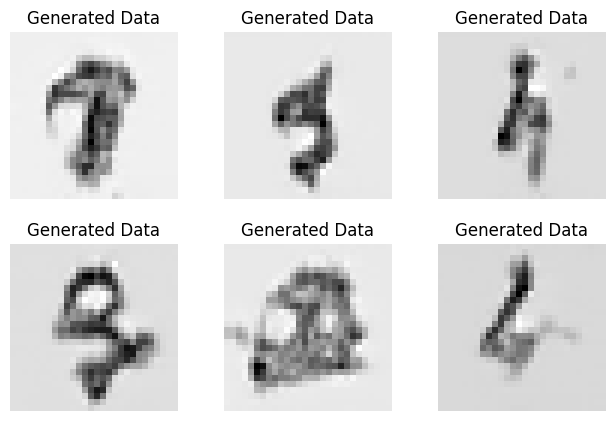

Epoch 68: 100%|██████████| 430/430 [00:24<00:00, 17.73it/s, v_num=27, g_loss=2.340, d_loss=0.255]epoch  68


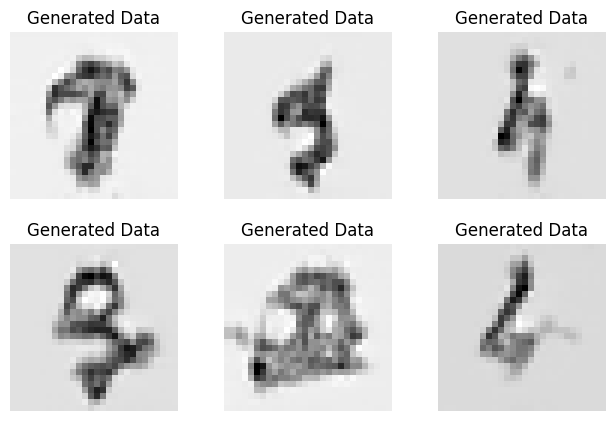

Epoch 69: 100%|██████████| 430/430 [00:24<00:00, 17.79it/s, v_num=27, g_loss=2.200, d_loss=0.268]epoch  69


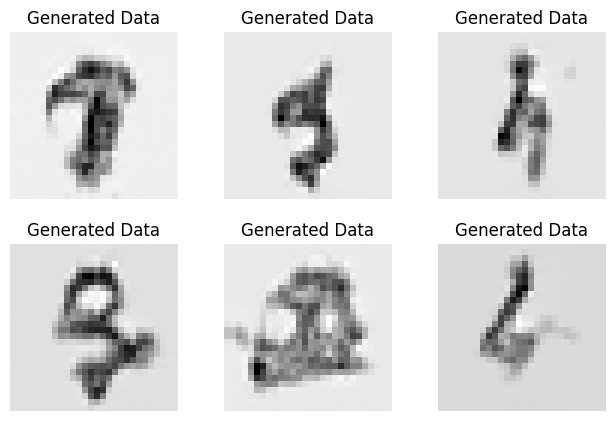

Epoch 70: 100%|██████████| 430/430 [00:24<00:00, 17.77it/s, v_num=27, g_loss=2.250, d_loss=0.246]epoch  70


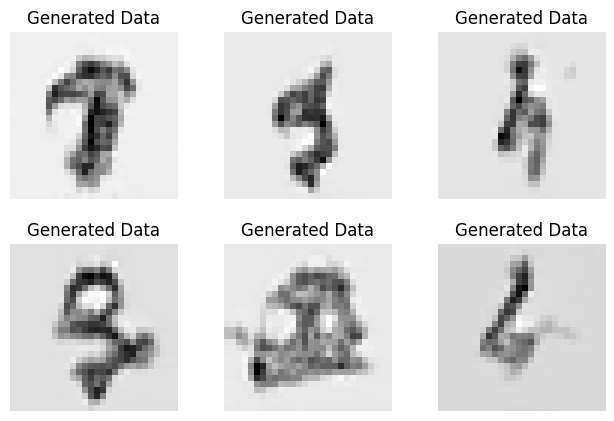

Epoch 71: 100%|██████████| 430/430 [00:24<00:00, 17.84it/s, v_num=27, g_loss=2.270, d_loss=0.194]epoch  71


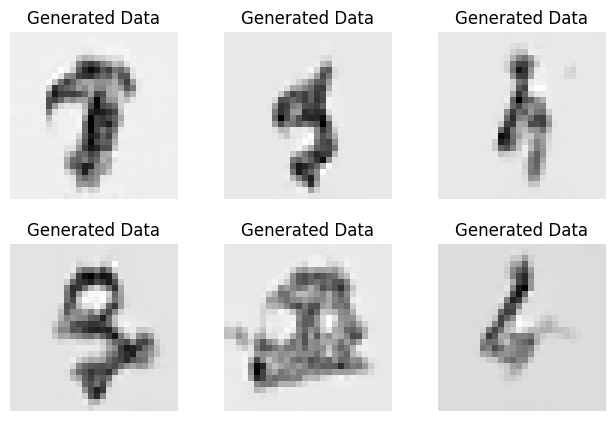

Epoch 72: 100%|██████████| 430/430 [00:24<00:00, 17.89it/s, v_num=27, g_loss=2.480, d_loss=0.200]epoch  72


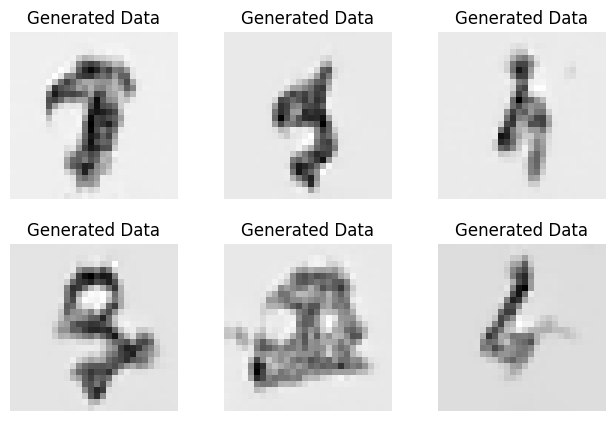

Epoch 73: 100%|██████████| 430/430 [00:24<00:00, 17.84it/s, v_num=27, g_loss=2.270, d_loss=0.213]epoch  73


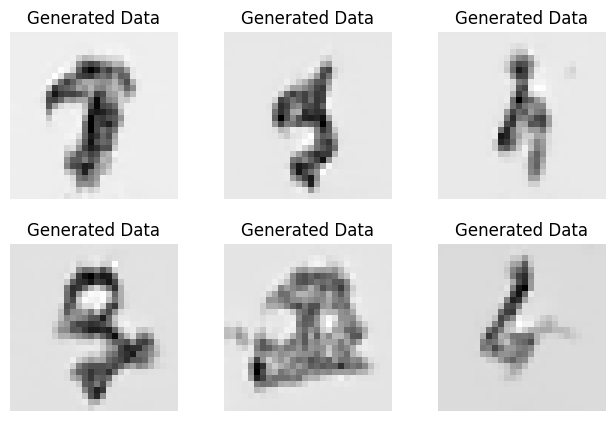

Epoch 74: 100%|██████████| 430/430 [00:25<00:00, 17.04it/s, v_num=27, g_loss=2.050, d_loss=0.258]epoch  74


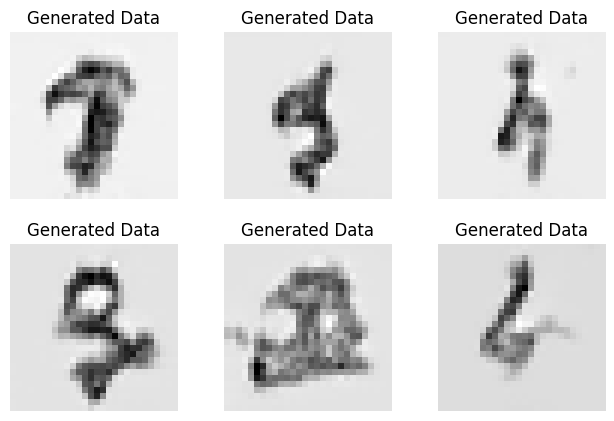

Epoch 75: 100%|██████████| 430/430 [00:24<00:00, 17.52it/s, v_num=27, g_loss=2.250, d_loss=0.236]epoch  75


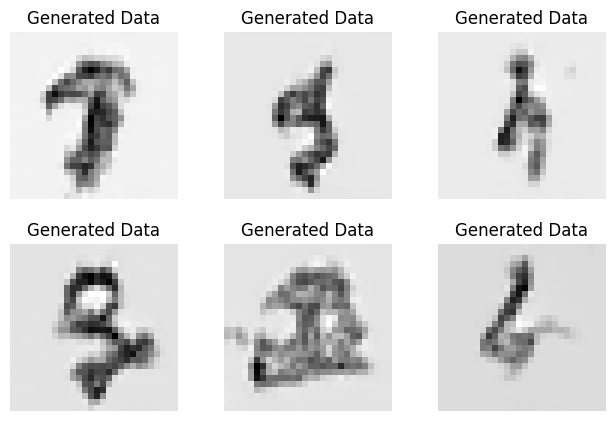

Epoch 76: 100%|██████████| 430/430 [00:24<00:00, 17.47it/s, v_num=27, g_loss=2.230, d_loss=0.253]epoch  76


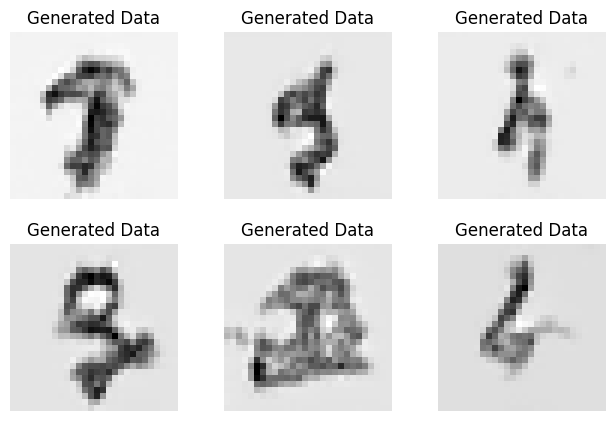

Epoch 77: 100%|██████████| 430/430 [00:24<00:00, 17.34it/s, v_num=27, g_loss=2.050, d_loss=0.265]epoch  77


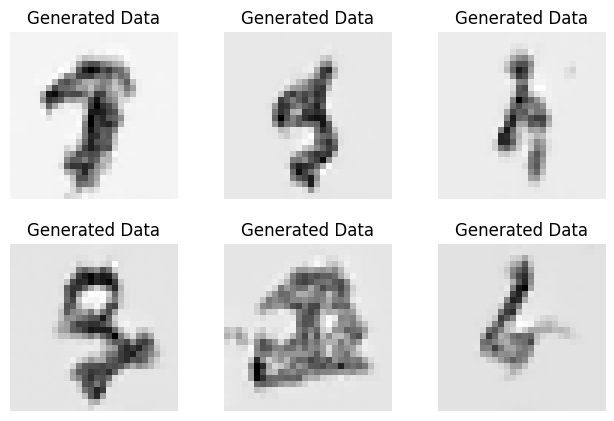

Epoch 78: 100%|██████████| 430/430 [00:24<00:00, 17.65it/s, v_num=27, g_loss=1.930, d_loss=0.284]epoch  78


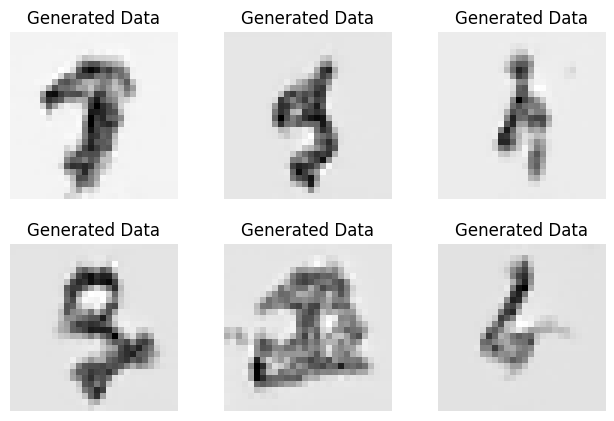

Epoch 79: 100%|██████████| 430/430 [00:24<00:00, 17.78it/s, v_num=27, g_loss=2.150, d_loss=0.253]epoch  79


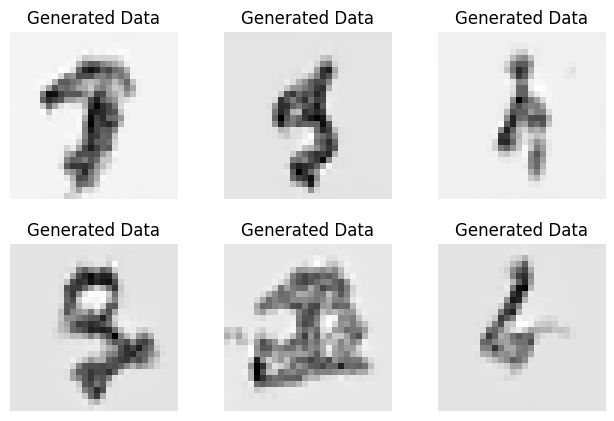

Epoch 80: 100%|██████████| 430/430 [00:24<00:00, 17.77it/s, v_num=27, g_loss=2.280, d_loss=0.281]epoch  80


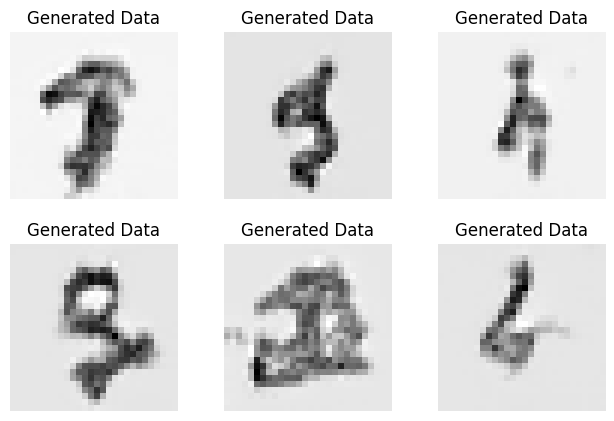

Epoch 81: 100%|██████████| 430/430 [00:24<00:00, 17.87it/s, v_num=27, g_loss=2.120, d_loss=0.266]epoch  81


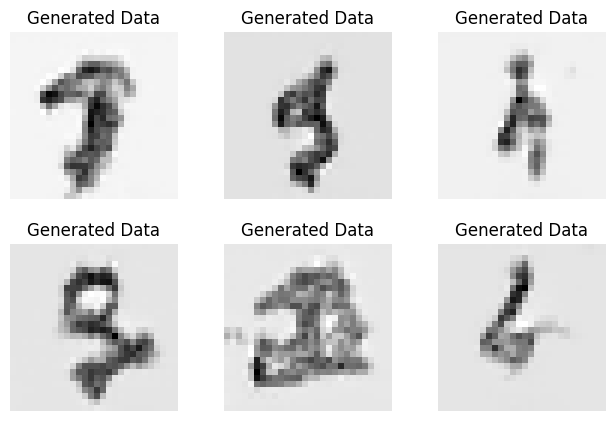

Epoch 82: 100%|██████████| 430/430 [00:23<00:00, 17.93it/s, v_num=27, g_loss=2.140, d_loss=0.286]epoch  82


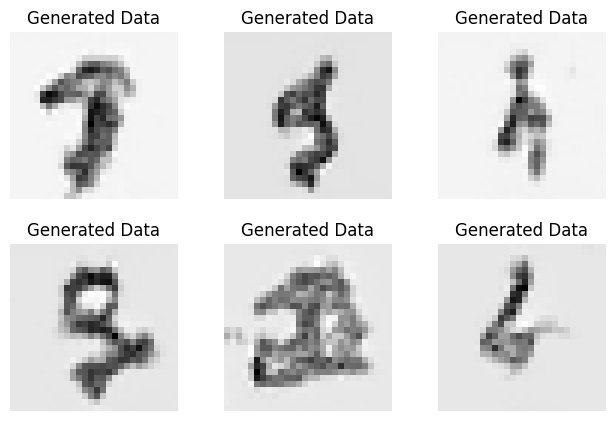

Epoch 83: 100%|██████████| 430/430 [00:24<00:00, 17.77it/s, v_num=27, g_loss=1.960, d_loss=0.304]epoch  83


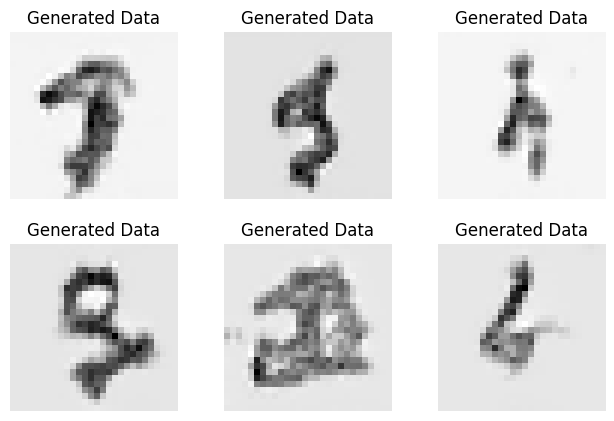

Epoch 84: 100%|██████████| 430/430 [00:24<00:00, 17.88it/s, v_num=27, g_loss=1.940, d_loss=0.266]epoch  84


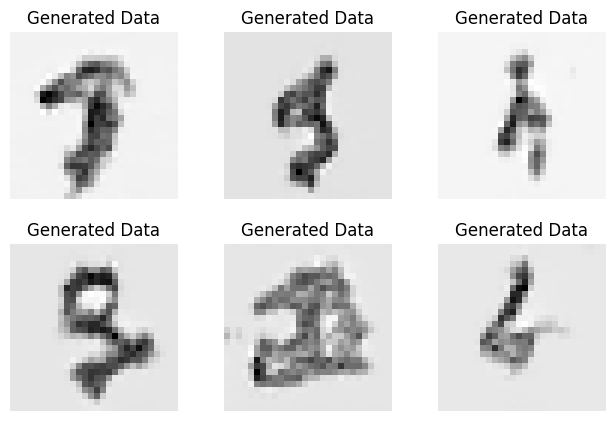

Epoch 85: 100%|██████████| 430/430 [00:24<00:00, 17.85it/s, v_num=27, g_loss=2.080, d_loss=0.234]epoch  85


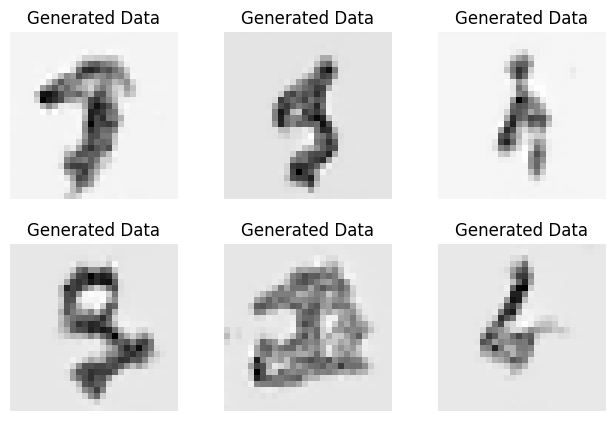

Epoch 86: 100%|██████████| 430/430 [00:24<00:00, 17.77it/s, v_num=27, g_loss=2.090, d_loss=0.316]epoch  86


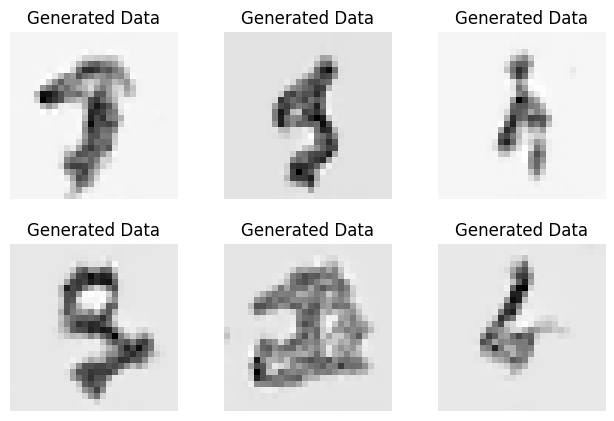

Epoch 87: 100%|██████████| 430/430 [00:24<00:00, 17.78it/s, v_num=27, g_loss=2.060, d_loss=0.318]epoch  87


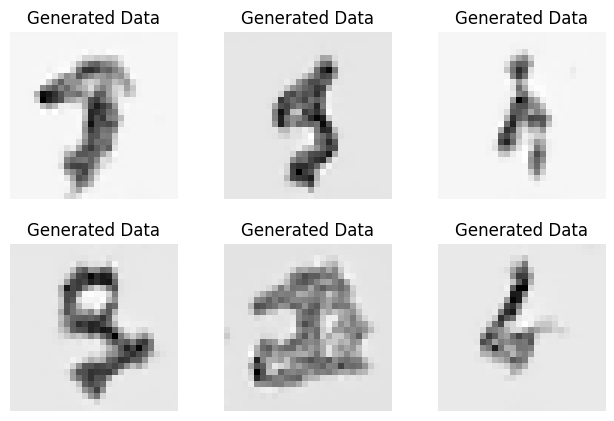

Epoch 88: 100%|██████████| 430/430 [00:24<00:00, 17.83it/s, v_num=27, g_loss=2.020, d_loss=0.317]epoch  88


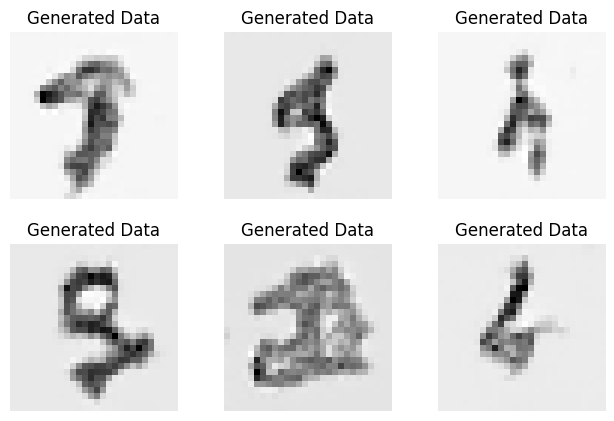

Epoch 89: 100%|██████████| 430/430 [00:25<00:00, 16.93it/s, v_num=27, g_loss=1.930, d_loss=0.347]epoch  89


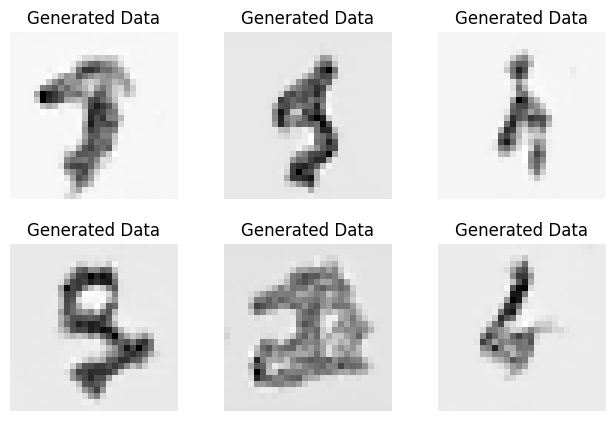

`Trainer.fit` stopped: `max_epochs=90` reached.


Epoch 89: 100%|██████████| 430/430 [00:25<00:00, 16.80it/s, v_num=27, g_loss=1.930, d_loss=0.347]


In [23]:
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model,dm)

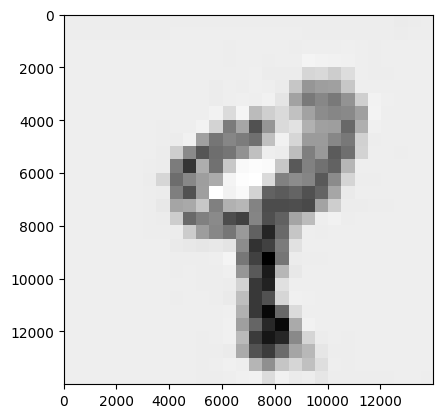

In [29]:
test = torch.randn(28, model.hparams.latent_dim)
test_img = model.generator(test)

from  torch.nn.modules.upsampling import Upsample
m = Upsample(scale_factor=500, mode='nearest')
x_upsampled = m(test_img)
plt.imshow(x_upsampled.detach()[0,0,:,:], cmap='gray_r' , interpolation='none')